In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Homework 4 - TEMPLATE - DO NOT DO IT YET

## References

+ Module 3: Uncertainty Propagation Through Scientific Models
    - Surrogate modeling
    - Active learning
    - Enforcing symmetries

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name:**
+ **Last Name:**
+ **Email:**
+ **Used generative AI to complete this assignment (Yes/No):**
+ **Which generative AI tool did you use (if applicable)?:**

# Problem 1 - Surrogate for expensive physical experiment

Permeable cement-stabilized base materials (PCBM) are engineered mixtures used in pavement construction to provide both structural support and drainage capabilities.
We will work with the experiment data in [Wang et. al., 2024](https://doi.org/10.1038/s41467-024-48766-4) where they fabricate several blocks of PCBM and measure various material properties

These are the inputs and outputs for the experiment:

- Inputs:
    1. **Cement content, $c$** [%]: How much cement is in the mixture
    2. **Compaction force, $F$** (kN): How much force is applied to compact the mixture during fabrication
- Outputs:
    1. **Compressive strength, $\sigma$** [MPa]
    2. **Permeability, $K$** [mm/s]
    3. **Porosity, $P$** [%]

Here is a diagram ([fig. 6 from the paper](https://www.nature.com/articles/s41467-024-48766-4/figures/6)) showing (a) the fabrication process and (b) the testing process:

<img src="https://raw.githubusercontent.com/PredictiveScienceLab/advanced-scientific-machine-learning/refs/heads/main/book/images/pcbm-fabrication-and-testing-cropped.png" alt="autoinjector" width="800"/>

Let's import the data:

In [2]:
import pandas as pd

# Import experiment data
experiment_data_url = 'https://github.com/PredictiveScienceLab/advanced-scientific-machine-learning/raw/refs/heads/main/book/data/pcbm/wang2024_pcbm_original_experimental_data.xlsx'
data = pd.read_excel(experiment_data_url)

####################################################################################
# TODO: Uncomment or delete these lines.

# NOTE: The following excel file just contains samples from the author's GP fit to the experiment data. 
#       I'm including these just in case we need to supplement the experimental data with some simulated data.

simulation_data_url = 'https://github.com/PredictiveScienceLab/advanced-scientific-machine-learning/raw/refs/heads/main/book/data/pcbm/wang2024_pcbm_kriging_surrogate_data1.xlsx'
data_sim = pd.read_excel(simulation_data_url, header=0)
####################################################################################

## (This is what the paper gives: One small dataset with the actual experiment measurements, one large dataset that is just samples from a GP fit to the small dataset.)

In [3]:
# Print data size
print('Experiment dataset size: ', data.shape[0])
print('Simulation dataset size: ', data_sim.shape[0])

Experiment dataset size:  27
Simulation dataset size:  442219


## (Here is the unscaled dataset)

<Axes: >

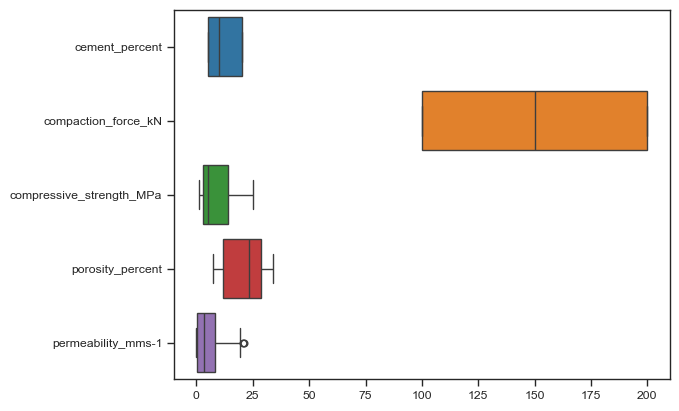

In [4]:
# Unscaled data
sns.boxplot(data=data, orient='h')

## (Here is the scaled dataset)

<Axes: >

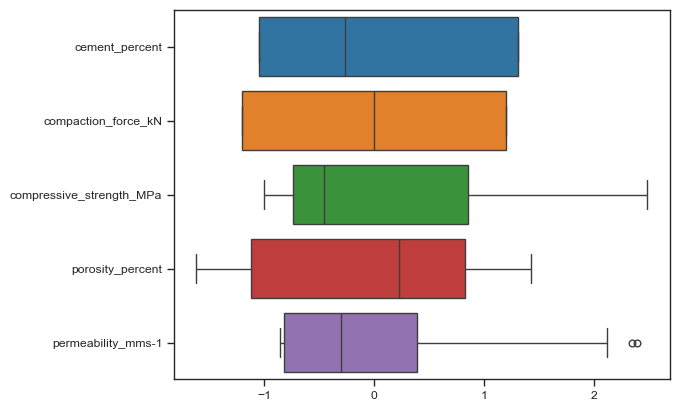

In [5]:
# Scaled data
def standardize(x):
    return (x - x.mean()) / x.std()

data_standardized = data.apply(standardize)
data_sim_standardized = data_sim.apply(standardize)

sns.boxplot(data=data_standardized, orient='h')

## (Another look at the data. First two rows are inputs, last three are outputs)

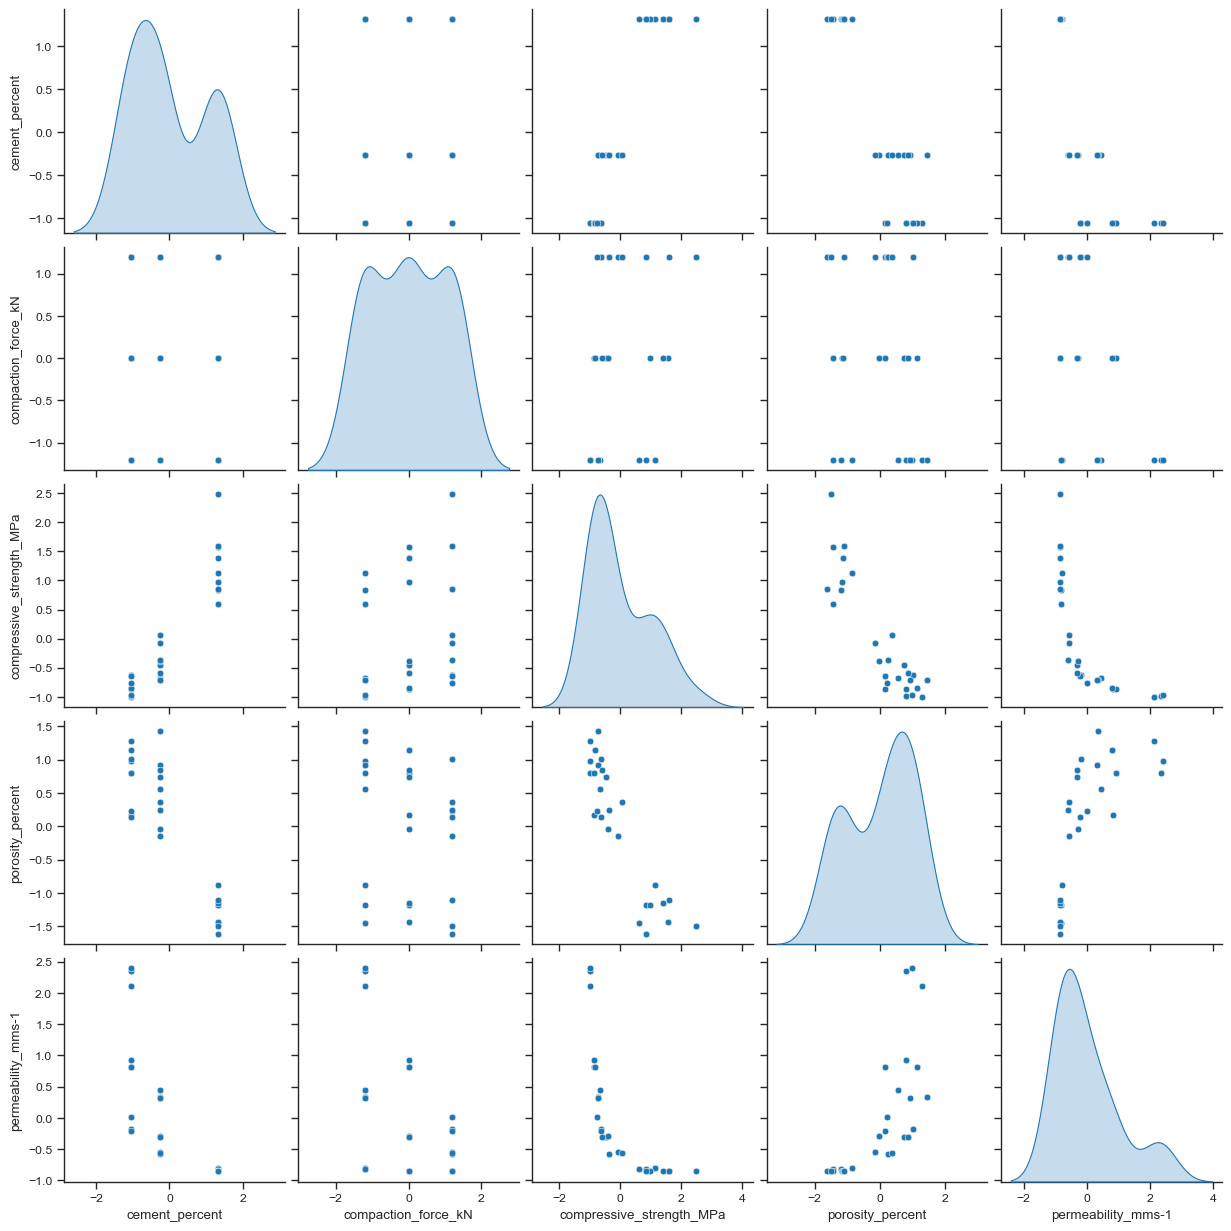

In [6]:
# Visualize the pairwise relationships between all inputs and outputs
sns.pairplot(data=data_standardized, diag_kind='kde')

## (Same thing, but now we are visualizing the samples GP samples from the paper. I'm guessing we don't need any of these "simulations", but put them here just in case)

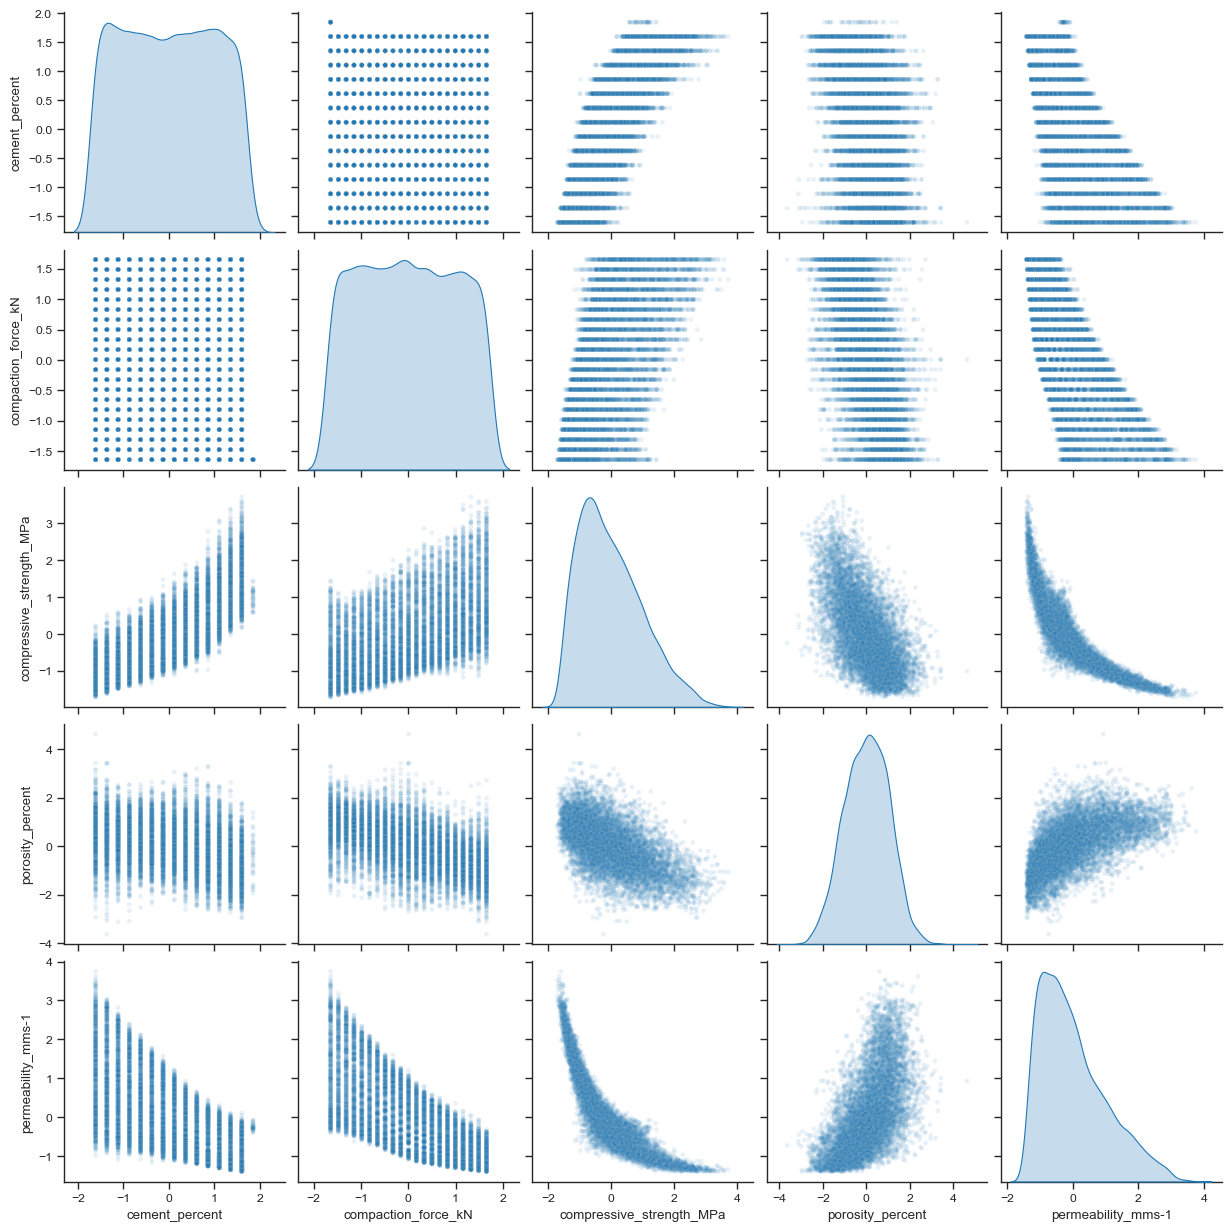

In [9]:
# Visualize the pairwise relationships between all inputs and outputs
import numpy as np
idx = np.random.randint(0, data_sim_standardized.shape[0], 10000)
sns.pairplot(data=data_sim_standardized.loc[idx], diag_kind='kde', plot_kws=dict(size=1, alpha=0.1))

## (Store the data in numpy arrays)

In [11]:
# Store the scaled data
input_names = ['cement_percent', 'compaction_force_kN']
output_names = ['compressive_strength_MPa', 'porosity_percent', 'permeability_mms-1']
X = data[input_names].values.astype(float)
Y = data[output_names].values.astype(float)